In [5]:
import gzip
import pandas as pd
import urllib
import tarfile
import urllib.request
import numpy as np
import random
import json
import bisect
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime, timedelta


In [6]:
url_item_data = "https://meli-data-challenge.s3.amazonaws.com/2020/item_data.jl.gz"
url_train_data = "https://meli-data-challenge.s3.amazonaws.com/2020/train_dataset.jl.gz"
url_test_data = "https://meli-data-challenge.s3.amazonaws.com/2020/test_dataset.jl.gz"

In [7]:
# PARA TRABAJAR CON UNA SAMPLE DEL TRAIN DATA SET:
# sample = 150000
# def binary_search(items, key, lo=0):
#     idx = bisect.bisect_left(items, key, lo)
#     if items[idx] != key:
#          return -1

#     return idx
# sample_list = random.sample(list(range(420000)),sample)
# sample_list.sort()
# ind = 0
# train_data = []
# with urllib.request.urlopen(url_train_data) as handle:
#   gz = gzip.GzipFile(fileobj=handle)
#   for i, line in enumerate(gz):
#     binary = binary_search(sample_list,i,ind)
#     if binary != -1:
#       train_data.append(json.loads(line.strip().decode('utf-8')))
#       ind = binary
train_data = []
with urllib.request.urlopen(url_train_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    train_data.append(json.loads(line.strip().decode('utf-8')))





In [8]:
df = pd.DataFrame(train_data)
del train_data
del gz

In [9]:
df

,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207
...,...,...
413158,"[{'event_info': 'PC GAMER', 'event_timestamp':...",459697
413159,"[{'event_info': 289961, 'event_timestamp': '20...",1845503
413160,"[{'event_info': 'ALUGUEL BOB CAT', 'event_time...",2022477
413161,"[{'event_info': 'XAOMI', 'event_timestamp': '2...",1111021


In [10]:
len(df.item_bought.unique())

64928

##El item comprado fue visto con anterioridad?
Sólo en el 29,38% de los casos

In [11]:
df['bought_was_viewed'] = df.apply(lambda row: row['item_bought'] in [history['event_info'] for history in row['user_history']], axis=1)
df.bought_was_viewed.value_counts(normalize=True)

False    0.706116
True     0.293884
Name: bought_was_viewed, dtype: float64

C:\Users\pipin\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'El item comprado fue visto con anterioridad? \n Sólo en el 29.38% de los casos')

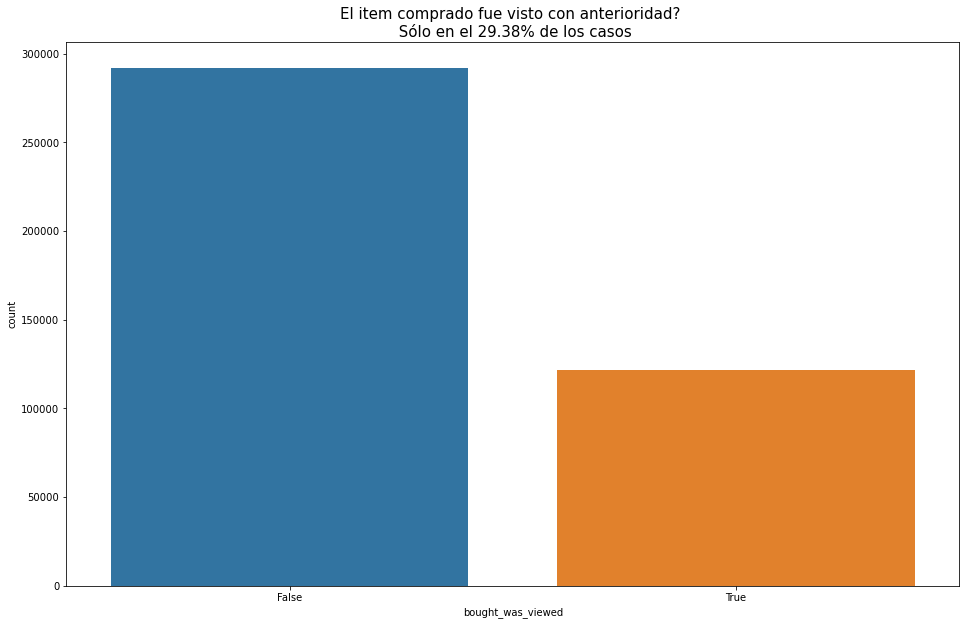

In [12]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.countplot(df['bought_was_viewed'], ax=axes)
axes.set_title('El item comprado fue visto con anterioridad? \n Sólo en el 29.38% de los casos', fontdict={'fontsize':15})

## Cuántas Views y cuántas Search por compra?

In [13]:
def count_event_type(list_of_events, type_of_event):
  count = 0
  for event in list_of_events:
    if event['event_type'] == type_of_event:
      count += 1
  return count

df['view_count'] = df.apply(lambda row: count_event_type(row['user_history'],'view'), axis = 1)
df['search_count'] = df.apply(lambda row: count_event_type(row['user_history'],'search'), axis = 1)
df['event_count'] = df.view_count + df.search_count

In [14]:
def count_bought_views(list_of_events, item_bought):
  count = 0
  for event in list_of_events:
    if event['event_type'] == 'view':
      if event['event_info'] == item_bought:
        count += 1
  return count

df['bought_view_count'] = df.apply(lambda row: count_bought_views(row['user_history'],row['item_bought']), axis = 1)

In [15]:
df.describe()

,item_bought,view_count,search_count,event_count,bought_view_count
count,4.131630e+05,413163.000000,413163.000000,413163.000000,413163.000000
mean,1.058022e+06,14.352730,14.689478,29.042209,1.223357
std,6.027066e+05,19.293081,20.457799,36.278935,2.914499
min,3.300000e+01,0.000000,0.000000,1.000000,0.000000
25%,5.482550e+05,2.000000,1.000000,5.000000,0.000000
50%,1.057231e+06,7.000000,7.000000,16.000000,0.000000
75%,1.584960e+06,18.000000,19.000000,39.000000,1.000000
max,2.102239e+06,342.000000,284.000000,566.000000,75.000000


Text(0.5, 1.0, 'Relación cantidad de searchs y views')

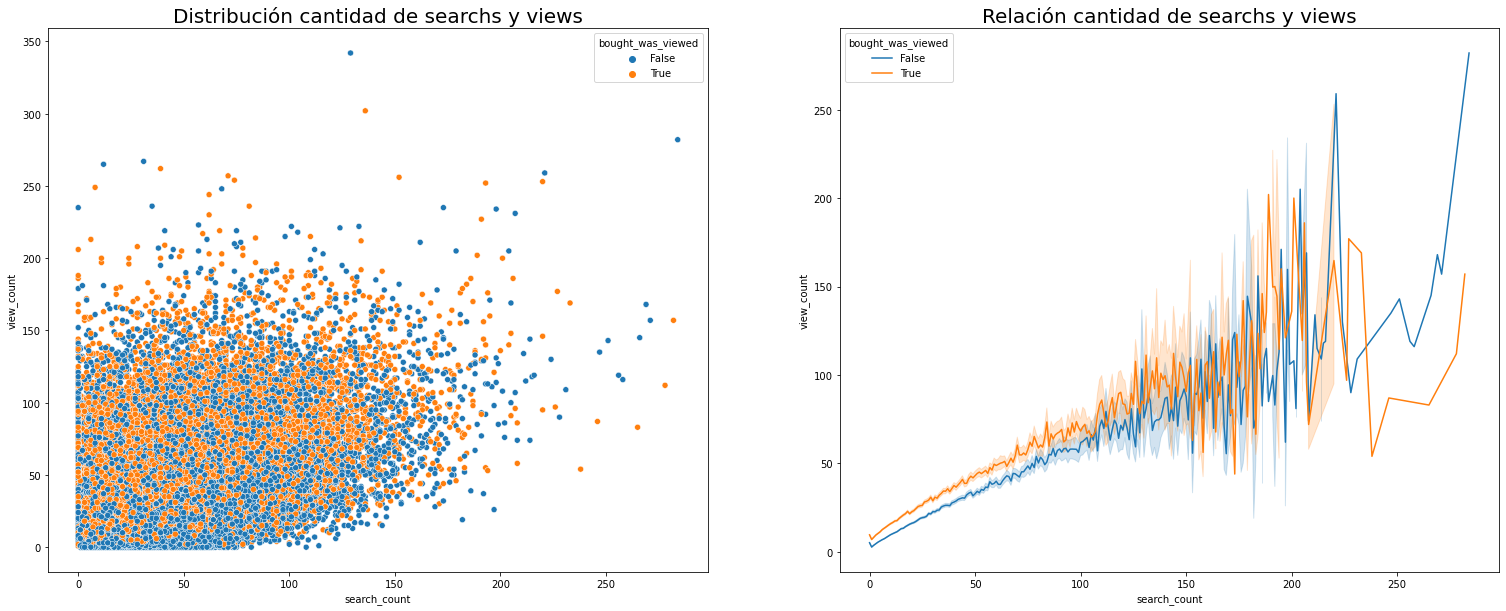

In [16]:
fig, axes = plt.subplots(1,2, figsize=(26,10))
# for ax in axes:
#   ax.set_xlim(0,30)
# sns.countplot(df.view_count, ax=axes[0], order=list(range(30)))
# sns.countplot(df.search_count, ax=axes[1], order=list(range(30)))
sns.scatterplot(x=df.search_count, y=df.view_count, ax=axes[0], 
                hue=df.bought_was_viewed)
sns.lineplot(x=df.search_count, y=df.view_count, ax=axes[1], 
                hue=df.bought_was_viewed)
axes[0].set_title('Distribución cantidad de searchs y views', fontdict={'fontsize': 20})
axes[1].set_title('Relación cantidad de searchs y views', fontdict={'fontsize': 20})

Text(0.5, 1.0, 'Zoom del descenso entre search = 0 y search=1')

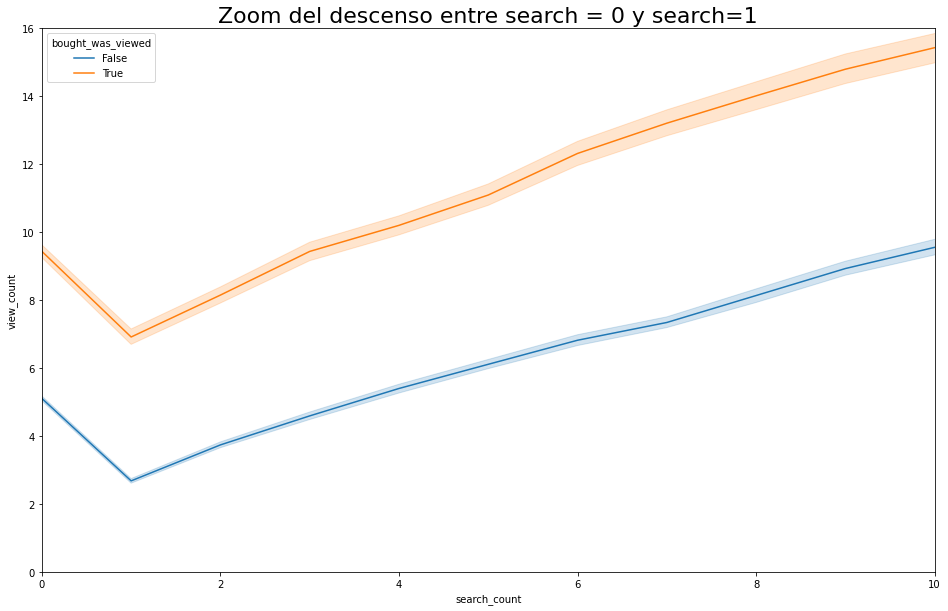

In [17]:
fig, ax = plt.subplots(1, figsize=(16,10))
# for ax in axes:
#   ax.set_xlim(0,30)
# sns.countplot(df.view_count, ax=axes[0], order=list(range(30)))
# sns.countplot(df.search_count, ax=axes[1], order=list(range(30)))
# sns.scatterplot(x=df.search_count, y=df.view_count, ax=axes[0], 
#                 hue=df.bought_was_viewed)
sns.lineplot(x=df[df.event_count < 100].search_count, y=df[df.event_count < 100].view_count, ax=ax, 
                hue=df[df.event_count < 100].bought_was_viewed)

ax.set_xlim(0,10)
ax.set_ylim(0,16)
ax.set_title('Zoom del descenso entre search = 0 y search=1', fontdict={'fontsize': 22})
# axes[0].set_title('Distribución cantidad de searchs y views', fontdict={'fontsize': 16})
# axes[1].set_title('Relación cantidad de searchs y views', fontdict={'fontsize': 16})

Por qué se ve un cambio tan marcado entre los que realizan 0 searches y el resto??
Podría tener que ver con que ante 0 searches, hay un mínimo de 1 view, mientras que con searches > 0, el mínimo de views es 0 y eso baja mucho el promedio. Sin embargo, filtrando el datasets con los casos donde views > 0, se ve un descenso similar del promedio de views entre 0 y 1 searches. Hay un universo de users que NO realizan searches, y su promedio de views es marcadamente más alto (usuarios que buscan por árbol de categoría? Que buscan a través de google?)

(0.0, 200.0)

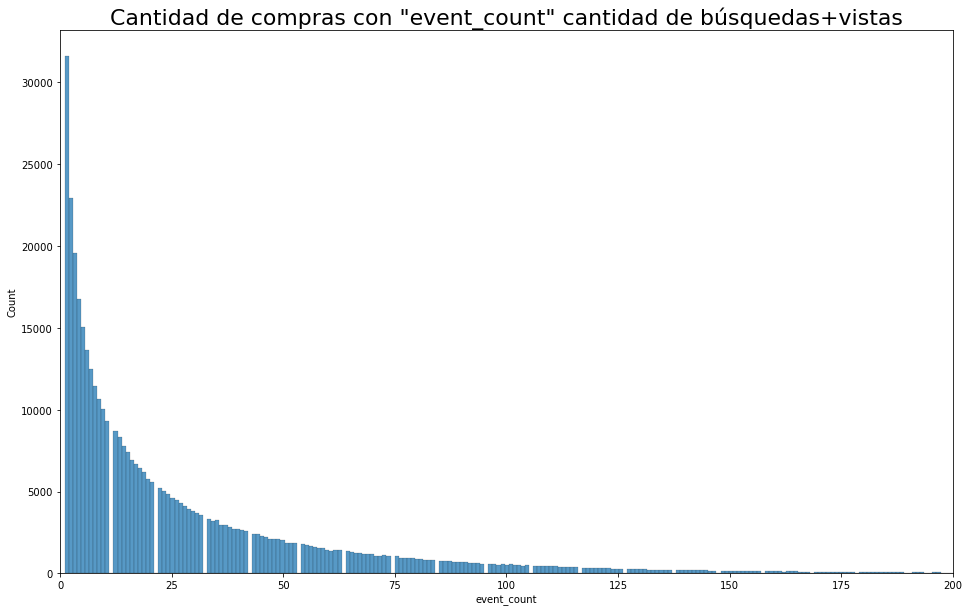

In [18]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.histplot(x=df.event_count, ax=axes)
axes.set_title('Cantidad de compras con "event_count" cantidad de búsquedas+vistas', fontdict={'fontsize': 22})
axes.set_xlim(0,200)

(0.0, 100.0)

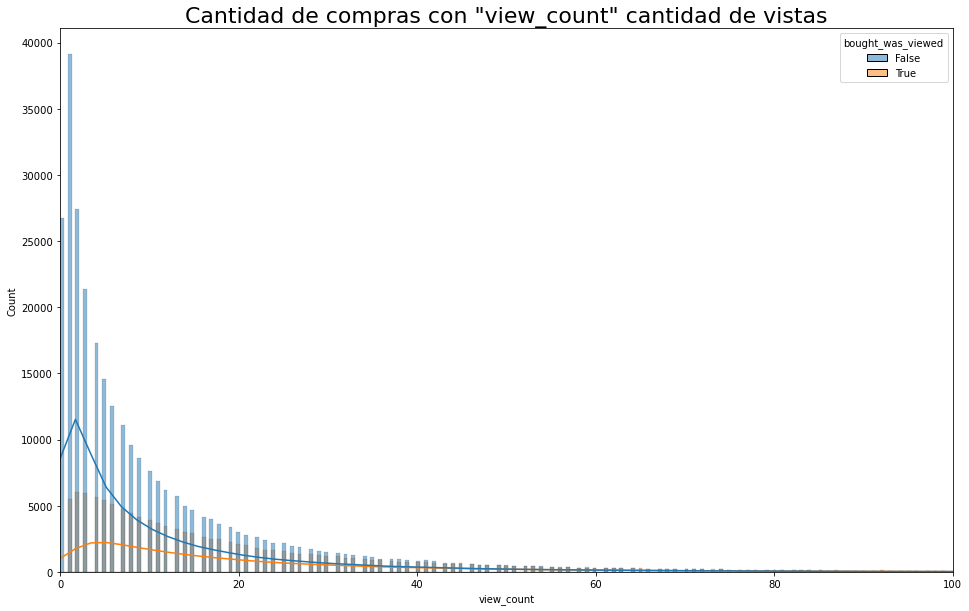

In [19]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.histplot(x=df.view_count, ax=axes, kde=True, hue=df.bought_was_viewed
             )
axes.set_title('Cantidad de compras con "view_count" cantidad de vistas', fontdict={'fontsize': 22})
axes.set_xlim(0,100)

(-1.0, 20.0)

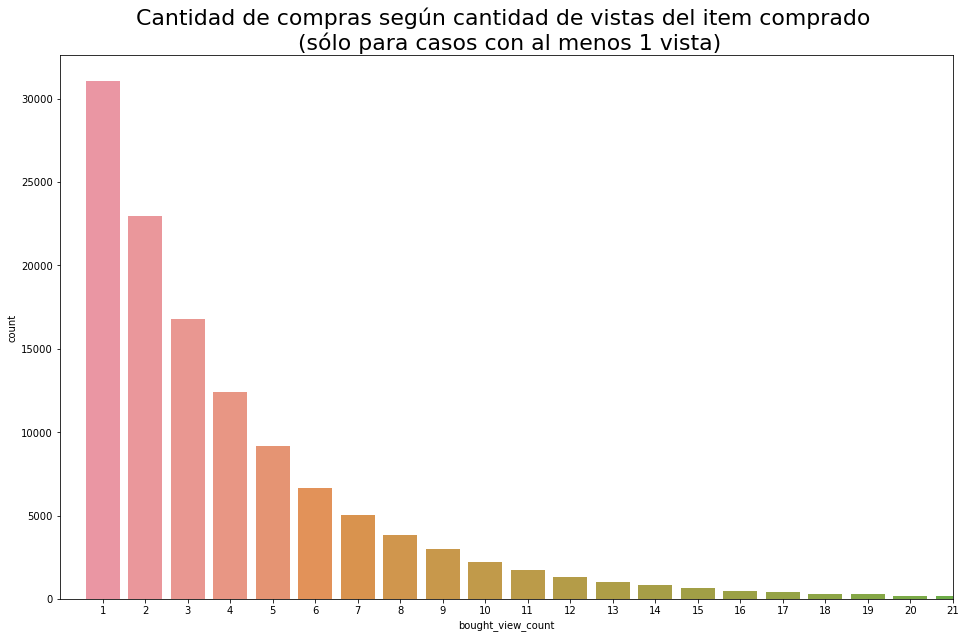

In [20]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.countplot(x=df[df.bought_was_viewed].bought_view_count, ax=axes
             )
axes.set_title('Cantidad de compras según cantidad de vistas del item comprado \n (sólo para casos con al menos 1 vista)', fontdict={'fontsize': 22})
axes.set_xlim(-1,20)

Text(0.5, 1.0, 'La relación entre vistas totales y vistas del ítem a comprar \n tiene un límite cercano a 10')

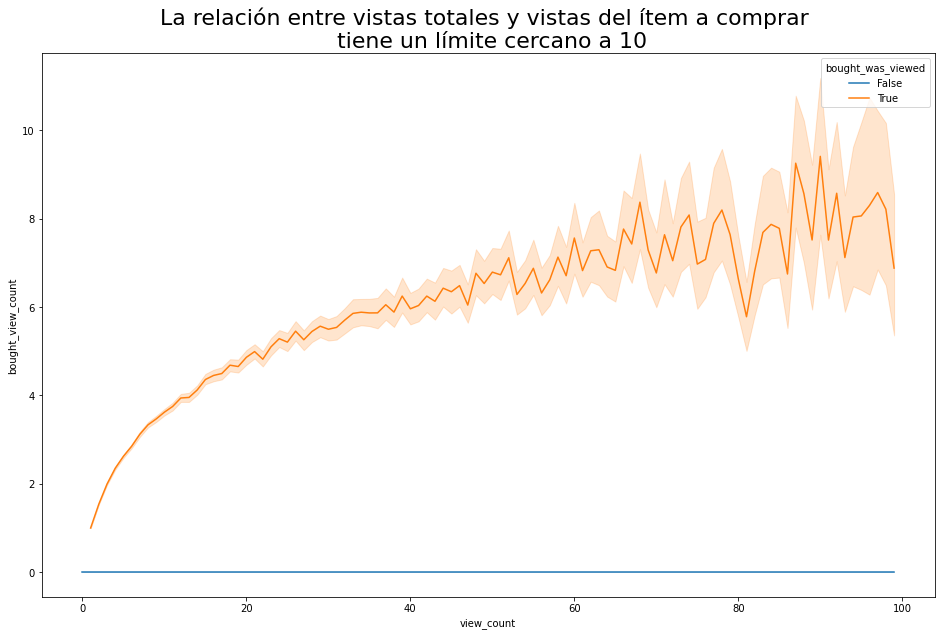

In [21]:
# sns.jointplot(data=df[df.view_count < 40], x='view_count', y='bought_view_count', 
#                 hue='bought_was_viewed', height=10, alpha=0.01, xlim=(0,200), ylim=(0,30))
fig, axes = plt.subplots(1, figsize=(16,10))
sns.lineplot(data=df[df.view_count < 100], x='view_count', y='bought_view_count', 
                hue='bought_was_viewed', ax=axes)
axes.set_title('La relación entre vistas totales y vistas del ítem a comprar \n tiene un límite cercano a 10', fontdict={'fontsize': 22})

# sns.jointplot(x=df.view_count, y=df.bought_view_count, 
#                 hue=df.bought_was_viewed, height=10, xlim=(-1,30), ylim=(-1,30), alpha=0.1)



Text(0.5, 1.0, 'Conforme aumentan las views totales, disminuye \n  la proporción de vistas del ítem a comprar')

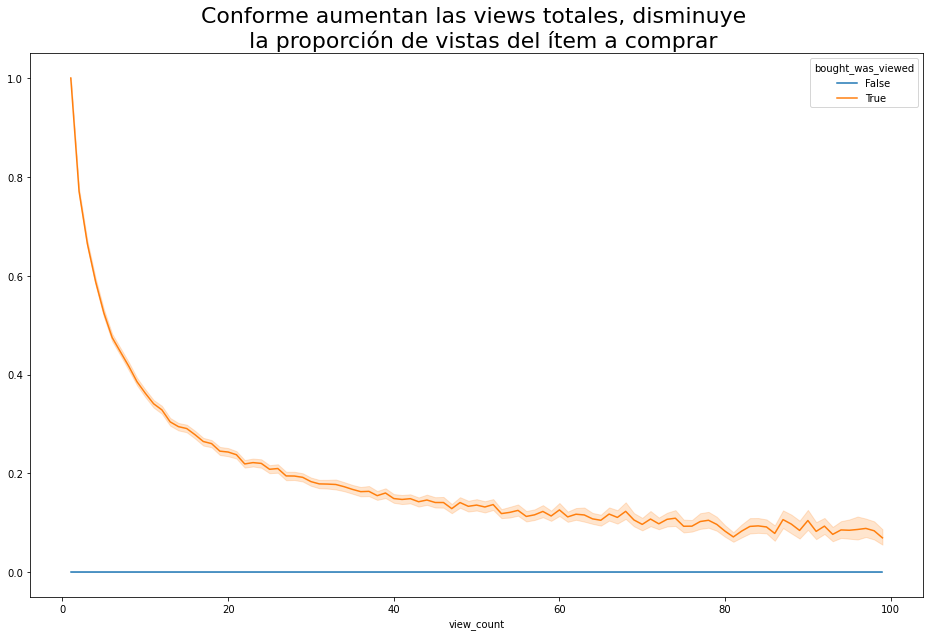

In [22]:
# sns.jointplot(data=df[df.view_count < 40], x='view_count', y='bought_view_count', 
#                 hue='bought_was_viewed', height=10, alpha=0.01, xlim=(0,200), ylim=(0,30))
fig, axes = plt.subplots(1, figsize=(16,10))
sns.lineplot(x=df[df.view_count < 100].view_count, y=df[df.view_count < 100].bought_view_count/df[df.view_count < 100].view_count, 
                hue=df[df.view_count < 100].bought_was_viewed, ax=axes)
axes.set_title('Conforme aumentan las views totales, disminuye \n  la proporción de vistas del ítem a comprar', fontdict={'fontsize': 22})

# sns.jointplot(x=df.view_count, y=df.bought_view_count, 
#                 hue=df.bought_was_viewed, height=10, xlim=(-1,30), ylim=(-1,30), alpha=0.1)

Esto nos marca que aunque un user sea muy activo, la cantidad de veces que mira el item que va a comprar tiene un límite superior. Esto hace más difícil predecir exactamente el ítem que va a comprar, ya que también está mirando muchos otros más.

<AxesSubplot:xlabel='bought_views_total_views_ratio', ylabel='Density'>

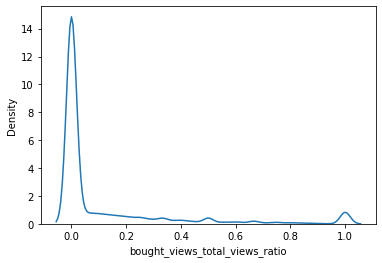

In [23]:
df['bought_views_total_views_ratio'] = df.bought_view_count / df.view_count
sns.kdeplot(df.bought_views_total_views_ratio)

Se puede observar 3 picos:
1. Pico en 0 (70% de casos que NO miran el item a comprar)
2. Pico en 0.5: Como las vistas descienden exponencialmente, hay mayor cantidad de casos con 2 o 4 views, con lo que es más probable encontrar ratios de 0.5.
3. Pico en 1: Gran cantidad de casos que miran únicamente lo que compran. 

In [24]:
len(df), len(df[(df.search_count < 150) & (df.view_count < 150)]), len(df[(df.search_count < 150) & (df.view_count < 150)])/len(df)

(413163, 412312, 0.9979402802283844)

Text(0.5, 1.0, 'Distribución de la cantidad de Vistas antes de una compra')

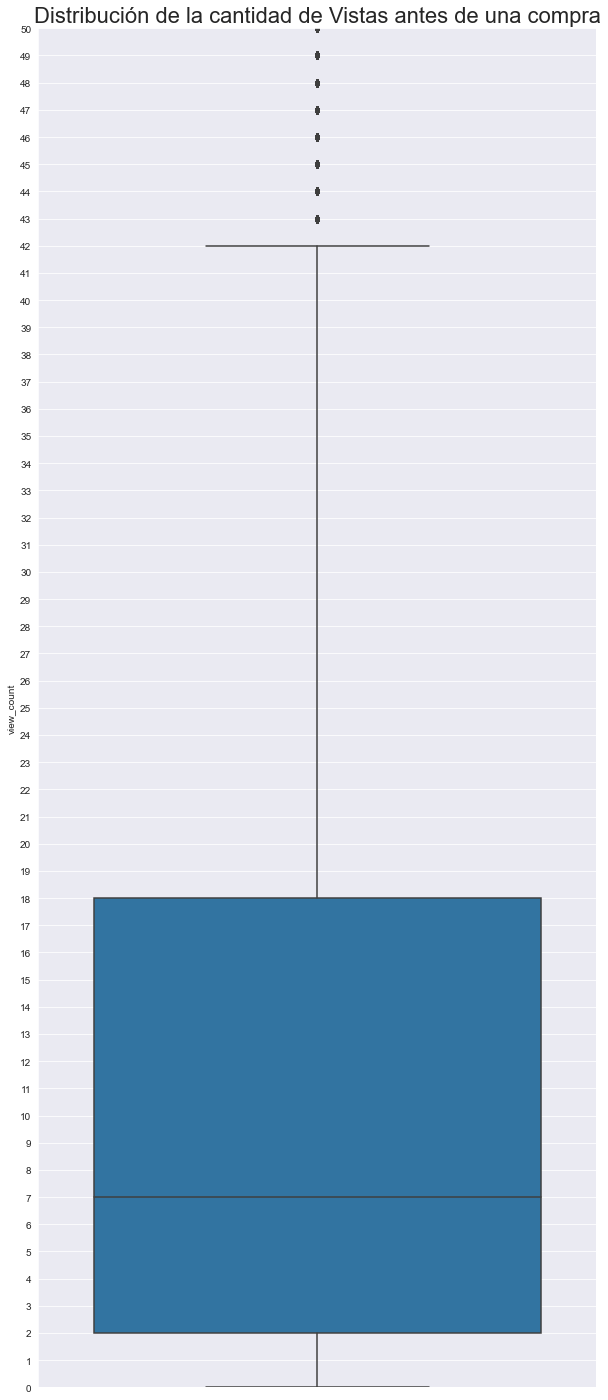

In [25]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,25))

sns.boxplot(y =df.view_count , ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,50)
ax.set_title('Distribución de la cantidad de Vistas antes de una compra', fontdict={'fontsize': 22})


Text(0.5, 1.0, 'Distribución de la cantidad de Vistas del item a comprar, antes de una compra')

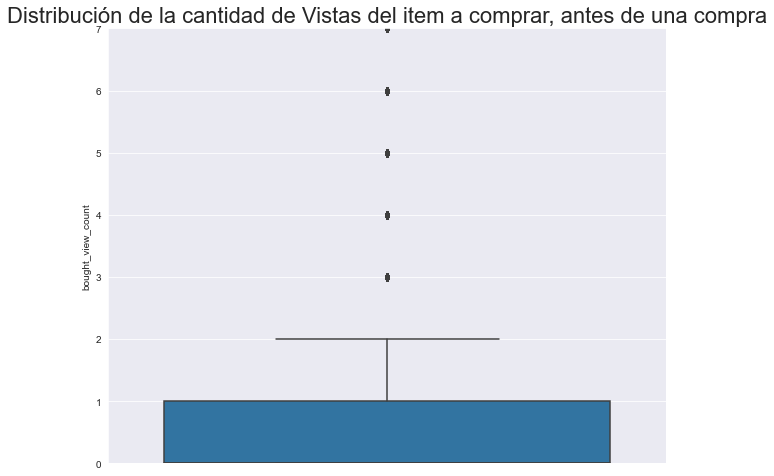

In [26]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,8))

sns.boxplot(y =df.bought_view_count , ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,7)
ax.set_title('Distribución de la cantidad de Vistas del item a comprar, antes de una compra', fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Distribución del ratio Vistas del item a comprar/total visto')

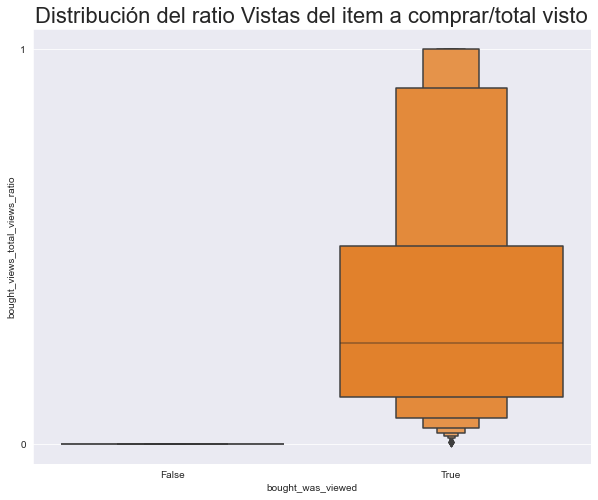

In [27]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,8))

sns.boxenplot(y =df.bought_views_total_views_ratio, x=df.bought_was_viewed, ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.set_ylim(0,1)
ax.set_title('Distribución del ratio Vistas del item a comprar/total visto', fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Distribución de la cantidad de Vistas del item a comprar, antes de una compra')

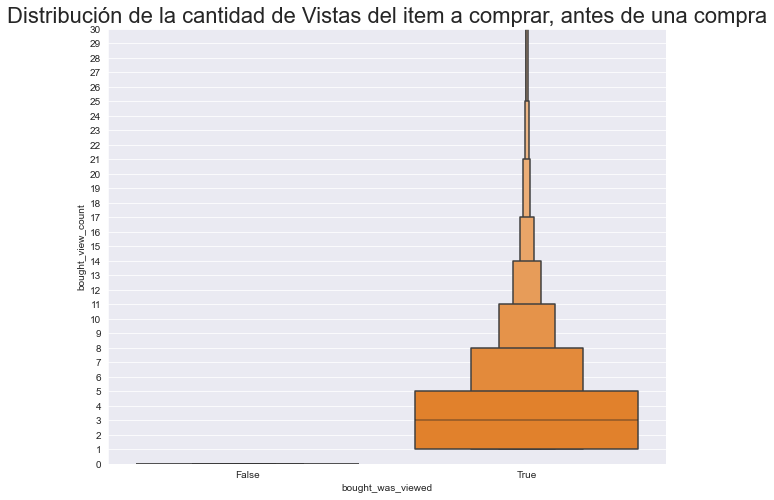

In [28]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,8))

sns.boxenplot(y =df.bought_view_count , x=df.bought_was_viewed, ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,30)
ax.set_title('Distribución de la cantidad de Vistas del item a comprar, antes de una compra', fontdict={'fontsize': 22})

## Se hace el Merge con los datos del item_data

In [29]:
item_data = []
with urllib.request.urlopen(url_item_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    item_data.append(json.loads(line.strip().decode('utf-8')))

itemdf = pd.DataFrame(item_data)

#Copia de itemdf para usos posteriores. 
idf=itemdf.copy()

del item_data
del gz

In [30]:
itemdf.head(2)

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800,1392.83,MLM151595,new


In [31]:
df.item_bought.isin(itemdf.item_id).value_counts()

True    413163
Name: item_bought, dtype: int64

In [32]:
df_joined = pd.merge(df, itemdf, left_on='item_bought', right_on='item_id', how='left')
df_joined.head(1)

,user_history,item_bought,bought_was_viewed,view_count,search_count,event_count,bought_view_count,bought_views_total_views_ratio,item_id,title,domain_id,product_id,price,category_id,condition
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830,False,18,1,19,0,0.0,1748830,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,None,90.00,MLB135384,new


## Análisis de la condición de artículos (usados vs nuevos) comprados en el dataset

In [33]:
df_joined.groupby('condition').describe()

item_bought                                                   \
                    count          mean            std       min       25%   
condition                                                                    
new              412637.0  1.057991e+06  602737.639023      33.0  547974.0   
not_specified       115.0  1.056598e+06  446958.580665  170833.0  745174.0   
used                411.0  1.089228e+06  609837.678604   12453.0  553962.5   

                                               view_count             ...  \
                     50%        75%        max      count       mean  ...   
condition                                                             ...   
new            1057231.0  1585033.0  2102239.0   412637.0  14.358250  ...   
not_specified   992454.0  1333797.0  2049655.0      115.0   9.469565  ...   
used           1171829.0  1497812.0  2094313.0      411.0  10.177616  ...   

              bought_views_total_views_ratio        item_id                \
                                         75%  max     count          mean   
condition                                                                   
new                                 0.100000  1.0  412637.0  1.057991e+06   
not_specified                       0.089273  1.0     115.0  1.056598e+06   
used                                0.166667  1.0     411.0  1.089228e+06   

                                                                        \
                         std       min       25%        50%        75%   
condition                                                                
new            602737.639023      33.0  547974.0  1057231.0  1585033.0   
not_specified  446958.580665  170833.0  745174.0   992454.0  1333797.0   
used           609837.678604   12453.0  553962.5  1171829.0  1497812.0   

                          
                     max  
condition                 
new            2102239.0  
not_specified  2049655.0  
used           2094313.0  

[3 rows x 56 columns]

Hay muy poco ítems no nuevos en nuestro dataset

### Análisis de la condición de item dentro de cada búsqueda

In [34]:
item_list_condition = itemdf['item_id'].tolist()
condition_list = itemdf['condition'].tolist()
condition_item_dict = dict(zip(item_list_condition, condition_list))

def find_condition(list_of_events, type_of_event, condition):
  count = 0
  for event in list_of_events:
    if event['event_type'] == type_of_event:
      condition_item = condition_item_dict[event['event_info']]
      if condition_item == condition:
        count += 1
  return count

df_joined['new_count'] = df_joined.apply(lambda row: find_condition(row['user_history'],'view', 'new'), axis = 1)
df_joined['use_count'] = df_joined.apply(lambda row: find_condition(row['user_history'],'view', 'used'), axis = 1)
df_joined['not_specified_count'] = df_joined.apply(lambda row: find_condition(row['user_history'],'view', 'not_specified'), axis = 1)

In [35]:
print('Porcentaje de users que han visto al menos 1 item NO nuevo:', sum((df_joined.use_count + df_joined.not_specified_count) > 0) / len(df_joined))
print('Porcentaje de users que han visto al menos 1 item usado:', sum((df_joined.use_count) > 0) / len(df_joined))
print('Porcentaje de users que han visto al menos 1 item no especificado:', sum((df_joined.not_specified_count) > 0) / len(df_joined))
df_joined[['new_count', 'use_count', 'not_specified_count']].describe()

Porcentaje de users que han visto al menos 1 item NO nuevo: 0.16136972574988565
Porcentaje de users que han visto al menos 1 item usado: 0.15261773198471307
Porcentaje de users que han visto al menos 1 item no especificado: 0.017174819623247968


,new_count,use_count,not_specified_count
count,413163.000000,413163.000000,413163.000000
mean,13.610379,0.692148,0.047277
std,18.585594,3.315653,0.719631
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,7.000000,0.000000,0.000000
75%,17.000000,0.000000,0.000000
max,332.000000,199.000000,103.000000


Se puede ver que la mayor parte de los users no han visto items de condición "usados", ni "no especificado". Sólo items nuevos.

Text(0.5, 1.0, 'Relación "Cantidad de eventos (views + searches)" VS. \n "items vistos no especificados"')

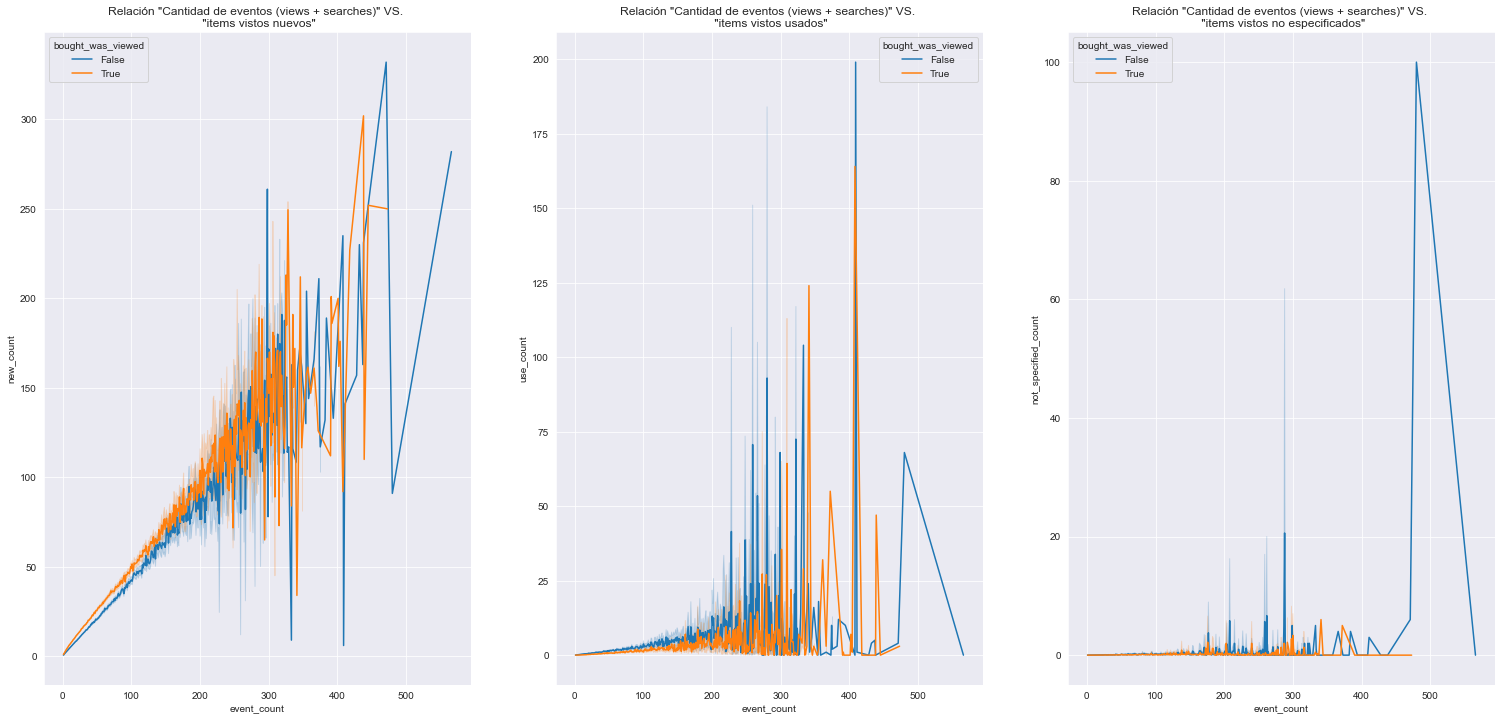

In [36]:
fig, axes = plt.subplots(1,3,figsize=(26,12))
sns.lineplot(data=df_joined, x='event_count', y='new_count', hue='bought_was_viewed',ax=axes[0])
axes[0].set_title('Relación "Cantidad de eventos (views + searches)" VS. \n "items vistos nuevos"')
sns.lineplot(data=df_joined, x='event_count', y='use_count', hue='bought_was_viewed', ax=axes[1])
axes[1].set_title('Relación "Cantidad de eventos (views + searches)" VS. \n "items vistos usados"')
sns.lineplot(data=df_joined, x='event_count', y='not_specified_count', hue='bought_was_viewed', ax=axes[2])
axes[2].set_title('Relación "Cantidad de eventos (views + searches)" VS. \n "items vistos no especificados"')

En base a los gráficos podemos concluir que los usuarios que miraron items de condición no especificada no realizaron muchas busquedas y compraron el item de una publicación que vieron. Los usuarios que miraron items usados en su mayoria terminan comprando un item usado y de una publicación que vieron. En cuanto para aquellos usurarios que miraron articulos nuevos en su mayoria terminan comprando articulos nuevos.

## Análisis de la procedencia de la compra: BRASIL (MLB) o MEXICO (MLM) en el dataset

In [37]:
df_joined.groupby(df_joined.domain_id.str[:4])[['view_count','search_count','event_count']].describe()

view_count                                                    \
               count       mean        std  min  25%  50%   75%    max   
domain_id                                                                
MLB-        354907.0  14.269335  19.263570  0.0  2.0  7.0  18.0  342.0   
MLM-         58256.0  14.860787  19.464348  0.0  3.0  8.0  19.0  257.0   

          search_count             ...              event_count             \
                 count       mean  ...   75%    max       count       mean   
domain_id                          ...                                       
MLB-          354907.0  14.683199  ...  19.0  284.0    354907.0  28.952534   
MLM-           58256.0  14.727736  ...  20.0  265.0     58256.0  29.588523   

                                                   
                 std  min  25%   50%   75%    max  
domain_id                                          
MLB-       36.318058  1.0  5.0  15.0  38.0  566.0  
MLM-       36.035162  1.0  6.0  16.0  40.0  438.0  

[2 rows x 24 columns]

Menos del 15% de las compras se realizaron en México

##Comparación: Conteo de categorías en tabla train_data y luego, conteo de categorías en tabla item_data
Sin diferenciar por pais



In [38]:
df_joined.groupby(df_joined.domain_id.str[4:]).count().sort_values(by='user_history', ascending=False).head(15)

,user_history,item_bought,bought_was_viewed,view_count,search_count,event_count,bought_view_count,bought_views_total_views_ratio,item_id,title,domain_id,product_id,price,category_id,condition,new_count,use_count,not_specified_count
domain_id,,,,,,,,,,,,,,,,,,
CELLPHONES,27017,27017,27017,27017,27017,27017,27017,25868,27017,27017,27017,23839,27017,27017,27017,27017,27017,27017
SNEAKERS,15016,15016,15016,15016,15016,15016,15016,14254,15016,15016,15016,1327,15016,15016,15016,15016,15016,15016
HEADPHONES,13656,13656,13656,13656,13656,13656,13656,12904,13656,13656,13656,6924,13656,13656,13656,13656,13656,13656
SUPPLEMENTS,10000,10000,10000,10000,10000,10000,10000,9214,10000,10000,10000,3875,10000,10000,10000,10000,10000,10000
SMARTWATCHES,9606,9606,9606,9606,9606,9606,9606,9104,9606,9606,9606,4527,9606,9606,9606,9606,9606,9606
VIDEO_GAMES,5289,5289,5289,5289,5289,5289,5289,4858,5289,5289,5289,1927,5289,5289,5289,5289,5289,5289
DOLLS,4956,4956,4956,4956,4956,4956,4956,4700,4956,4956,4956,241,4956,4956,4956,4956,4956,4956
BOOTS_AND_BOOTIES,4469,4469,4469,4469,4469,4469,4469,4181,4469,4469,4469,0,4469,4469,4469,4469,4469,4469
STREAMING_MEDIA_DEVICES,4415,4415,4415,4415,4415,4415,4415,4147,4415,4415,4415,1988,4415,4415,4415,4415,4415,4415


###Conteo de categorías en tabla item_data:
Sin diferenciar por pais

In [39]:
itemdf.groupby(itemdf.domain_id.str[4:]).count().sort_values(by='title', ascending=False).head(15)

,item_id,title,domain_id,product_id,price,category_id,condition
domain_id,,,,,,,
CARS_AND_VANS,55585,55585,55585,44775,55585,55585,55585
CELLPHONES,46425,46425,46425,40234,46425,46425,46425
SNEAKERS,42460,42460,42460,1045,42460,42460,42460
VEHICLE_ACCESSORIES,34011,34011,34011,32,34011,34011,34011
T_SHIRTS,28130,28130,28130,6,28130,28130,28130
DRESSES,24981,24981,24981,12,24981,24981,24981
SUPPLEMENTS,24111,24111,24111,8017,24111,24111,24111
VEHICLE_PARTS,21739,21739,21739,4,21739,21739,21739
CELLPHONE_COVERS,18652,18652,18652,32,18652,18652,18652


### Conclusión: Del dataset que tenemos, MELI ha eliminado los siguientes domains importantes:

In [40]:
train_domains_list = df_joined.groupby(df_joined.domain_id.str[4:]).count().sort_values(by='user_history', ascending=False).index.tolist()
item_domains_list = itemdf[['domain_id','title']].groupby(itemdf.domain_id.str[4:]).count().sort_values(by='title', ascending=False).index
itemdf[['domain_id','title']].groupby(itemdf.domain_id.str[4:]).count().sort_values(by='title', ascending=False)[~item_domains_list.isin(train_domains_list)].head(20)

,domain_id,title
domain_id,,
CARS_AND_VANS,55585,55585
MOTORCYCLES,12818,12818
TRUCKS,5618,5618
CLASSIC_CARS,4793,4793
INDIVIDUAL_HOUSES_FOR_SALE,3577,3577
HOUSES_FOR_RENT,1527,1527
INDIVIDUAL_APARTMENTS_FOR_SALE,1411,1411
BUSES,1376,1376
RACKS_AND_PINIONS,1359,1359


Nuestra predicción entonces no tendrá poder sobre todos estos domains, que han sido eliminados del dataset original

## Items más comprados en el dataset

In [41]:
df_joined.title.value_counts()[:20]

Xiaomi Redmi Note 7 (48 Mpx) Dual Sim 64 Gb Space Black 4 Gb Ram    938
Fone De Ouvido Bluetooth Xiaomi Redmi Airdots                       609
Xiaomi Redmi Note 7 Dual Sim 64 Gb Neptune Blue 4 Gb Ram            608
Celular Samsung Galaxy A30 Dual 64gb 4gb Ram A305 Azul              559
Relogio Bluetooth Wifi Smartwatch A1 Camera Celular Chip            490
Aparelho De Som Carro Automotivo Bluetooth Pendrive Sd Rádio        482
Audífonos Manos Libres Tipo AirPods I7s Bluetooth 5.0 Pop Up        443
Bebê Reborn 21 Itens Princesa Boneca Senta Silicone Bolsa           398
Fone De Ouvido I7 Tws Bluetooth AirPods iPhone Android S/fio        397
Boneca Reborn Bebê Realista 14 Itens Pronta Entrega Menina          378
Hoverboard 6.5 Bluetooth Bateria Samsung Com Led + Bolsa            348
Xiaomi Mi 8 Lite Dual Sim 128 Gb Midnight Black                     346
Smart Tv Led 32 Samsung Lh32benelga 2 Hdmi 1 Usb Wifi               335
Maquininha Point Mini - A Máquina De Cartão Do Mercado Pago     

In [42]:
pd.merge(pd.DataFrame(df_joined.item_bought.value_counts()[:10]).reset_index(), df_joined[['item_id','title']].drop_duplicates(['item_id','title']),  left_on='index', right_on='item_id', how='left')

,index,item_bought,item_id,title
0,1587422,558,1587422,Fone De Ouvido Bluetooth Xiaomi Redmi Airdots
1,1803710,384,1803710,Bebê Reborn 21 Itens Princesa Boneca Senta Sil...
2,10243,371,10243,Boneca Reborn Bebê Realista 14 Itens Pronta En...
3,548905,348,548905,Hoverboard 6.5 Bluetooth Bateria Samsung Com L...
4,1906937,344,1906937,Fone De Ouvido I7 Tws Bluetooth AirPods iPhone...
5,716822,330,716822,Audifonos Bluetooth 5.0 Manos Libres I7s AirP...
6,1361154,326,1361154,Relogio Bluetooth Wifi Smartwatch A1 Camera Ce...
7,1716388,324,1716388,Smart Tv Led 32 Samsung Lh32benelga 2 Hdmi 1 U...
8,725371,322,725371,Miband 4 Global Original Lacrado.pronto Entreg...
9,859574,322,859574,Xiaomi Redmi Note 7 Global 64/4gb Global + Cap...


Los items difieren si se ordenan por item_id que por título. **Esto es porque hay muchos item_id que comparten exactamente el mismo título:**

In [43]:
print('CANTIDAD DE ITEM_ID QUE COMPARTEN EXACTAMENTE EL MISMO TÍTULO:')
df_joined.drop_duplicates(['item_bought', 'title']).groupby('title')['item_bought'].count().sort_values(ascending=False).head(10)

CANTIDAD DE ITEM_ID QUE COMPARTEN EXACTAMENTE EL MISMO TÍTULO:


title
Xiaomi Redmi Note 7 (48 Mpx) Dual Sim 64 Gb Space Black 4 Gb Ram     47
Win10 Pro Key Serial Chave Licença 100% Orignal Ativa Online         41
Xiaomi Redmi Note 7 (48 Mpx) Dual Sim 64 Gb Neptune Blue 4 Gb Ram    28
Xiaomi Redmi Note 7 Dual Sim 64 Gb Neptune Blue 4 Gb Ram             26
Xiaomi Mi A3 Dual Sim 64 Gb Acinzentado 4 Gb Ram                     25
Office 2019 Pro Plus Licencia 365 - 5 Pc - Mac - iPad - 2016         24
Assista Aos Jogos Do Seu Time Ao Vivo Premiere Play 1 Ano            22
Xiaomi Redmi 7 Dual Sim 32 Gb Azul-cometa 3 Gb Ram                   21
Xiaomi Mi A3 Dual Sim 64 Gb Azulón 4 Gb Ram                          21
Licença Office 2019 Original + Chave Original 25 Digitos             21
Name: item_bought, dtype: int64

## ANÁLISIS DE LOS PRECIOS DE LOS ITEMS **COMPRADOS**

In [44]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_joined['price_float'] = df_joined['price'].astype(float)
df_joined.price_float.describe()

count      413163.000
mean         2886.124
std        492725.714
min             0.010
25%            62.000
50%           139.900
75%           261.000
max     100000000.000
Name: price_float, dtype: float64

###Promedio de precio de los items vistos

In [45]:
item_list = itemdf['item_id'].tolist()
price_list = itemdf['price'].astype(float).tolist()
item_price_dict = dict(zip(item_list, price_list))

def find_mean_price_of_viewed(row):
  prices=[]
  for event in row.user_history:
        if event['event_type'] == 'view':
          prices.append(item_price_dict[event['event_info']])
  if prices:
    return sum(prices) / len(prices) #PROMEDIO de prices
  else:
    return np.nan

df_joined['viewed_prices_mean'] = df_joined.apply(find_mean_price_of_viewed, axis=1)

### Relación "Promedio de precio de items vistos" vs "Precio del item comprado"
Separado según users que vieron previamente el item que terminaron comprando, y los que no

Text(0.5, 1.0, 'Relación "Promedio de precios de lo visto" VS. \n "Precio del item comprado"')

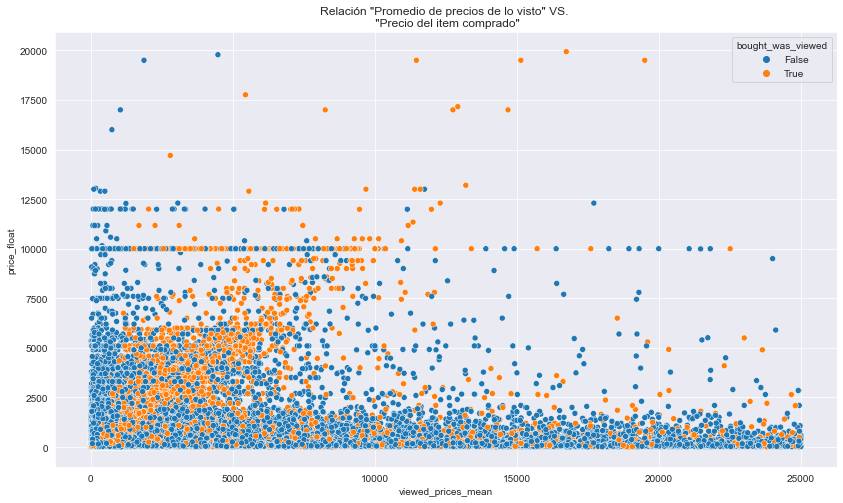

In [46]:
fig, ax = plt.subplots(1,figsize=(14,8))
sns.scatterplot(data=df_joined[(df_joined.price_float < 25000) & (df_joined.viewed_prices_mean < 25000)], x='viewed_prices_mean', y='price_float', hue='bought_was_viewed', ax=ax)
ax.set_title('Relación "Promedio de precios de lo visto" VS. \n "Precio del item comprado"')
# sns.lineplot(data=df_joined[(df_joined.price_float < 25000) & (df_joined.viewed_prices_mean < 25000)], x='viewed_prices_mean', y='price_float', hue='bought_was_viewed', ax=axes[1])

### Relación "cantidad de eventos (views+searches) del user" vs "Precio del item comprado"

Text(0.5, 1.0, 'Relación "Cantidad de eventos (views + searches)" VS. \n "Precio del item comprado"')

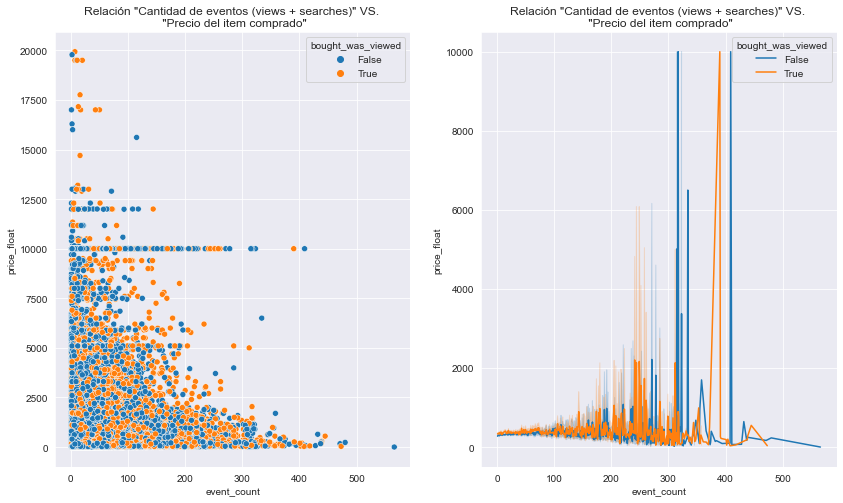

In [47]:
fig, axes = plt.subplots(1,2,figsize=(14,8))
sns.scatterplot(data=df_joined[(df_joined.price_float < 25000) ], x='event_count', y='price_float', hue='bought_was_viewed',ax=axes[0])
axes[0].set_title('Relación "Cantidad de eventos (views + searches)" VS. \n "Precio del item comprado"')
sns.lineplot(data=df_joined[(df_joined.price_float < 25000) ], x='event_count', y='price_float', hue='bought_was_viewed', ax=axes[1])
axes[1].set_title('Relación "Cantidad de eventos (views + searches)" VS. \n "Precio del item comprado"')

Se observa:


1.   Hay algún tipo de ruido en la columna "Price". Se ve el precio 10000 repetido más de la cuenta, gracias a los scatterplot.
2.   Hay una relación entre el precio de lo visto y el precio de lo finalmente comprado, para los casos de users que vieron lo que terminaron comprando (lo que era probable, siendo que la mayor parte de los users hacen muy pocas vistas totales, por lo que la mayoría vieron únicamente lo que terminaron comprando)
3. No parece haber una relación entre el promedio de precios y el item comprado para los users que NO miraron el item que terminan comprando
4. Mirando el scatterplot, pareciera haber una relación (decreciente) entre cantidad de eventos (views+searches) y el precio del item comprado... Pero esto no es real. Lo que ocurre es que al haber una mayor cantidad de casos con bajos eventos, el spread del precio es mayor (esto se confirma con el lineplot).
5. Se debe reanalizar el punto 3 tomando únicamente las vistas del domain de la compra para el promedio de precios. 



## Análisis de nulls en item_data

In [48]:

for col in itemdf.columns:
  print(col, len(itemdf[itemdf[col].isnull()]))

item_id 0
title 0
domain_id 851
product_id 1805749
price 339
category_id 0
condition 856


Muchos nulls en itemdf para el product_id. Muy pocos para las demás columnas.

##Cantidad de puntos donde se vio items en más de un país: 44 / 413000

In [49]:
item_list = itemdf['item_id'].tolist()
domain_list = itemdf['domain_id'].tolist()
item_domain_dict = dict(zip(item_list, domain_list))

In [50]:
def count_countries(history):
  countries = []
  for hist in history:
    if hist['event_type'] == 'view':
      # country = itemdf[itemdf.item_id == hist['event_info']].domain_id.str[:3].values[0]
      # # print(type(country))
      country = item_domain_dict[hist['event_info']]
      if country:
        countries.append(country[:3])
  return len(set(countries))

df_joined['multiple_countries'] = df_joined.user_history.apply(count_countries) 
# df_joined['multiple_countries'] = df_joined.user_history.apply(lambda events: (len(set([itemdf[itemdf.item_id == int(float(history['event_info']))].domain_id.str[:3] for history in events if history['event_type'] == 'view'])) != 1)) 
df_joined.multiple_countries.value_counts()

1    386291
0     26828
2        44
Name: multiple_countries, dtype: int64

Por ende las poblaciones están afortunadamente muy separadas

##El domain de la compra estuvo entre los items vistos? 
Cierto para aprox el 50% de los casos (203857 sobre 413163)

In [51]:
df_joined['domain_was_searched'] = df_joined.apply(lambda row: row['domain_id'] in [item_domain_dict[history['event_info']] for history in row['user_history'] if history['event_type'] == 'view'], axis=1)
df_joined.domain_was_searched.value_counts()

False    209306
True     203857
Name: domain_was_searched, dtype: int64

Text(0.5, 1.0, 'Comparación abierta por vistas \n totales en el history')

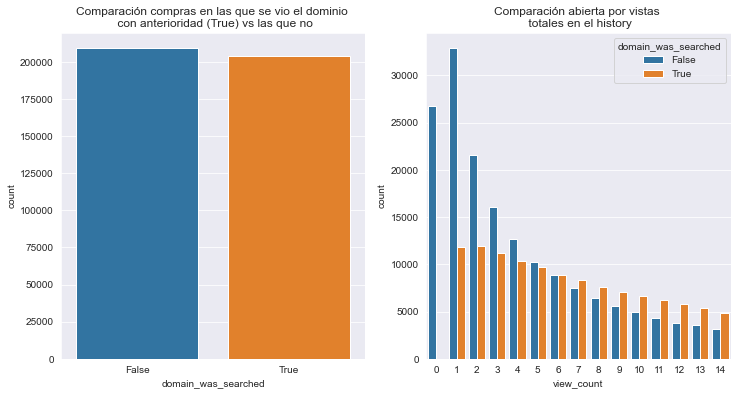

In [52]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.countplot(data=df_joined, x='domain_was_searched', ax=axes[0])
sns.countplot(data=df_joined[df_joined.view_count < 15], x='view_count', hue='domain_was_searched', ax=axes[1])
axes[0].set_title('Comparación compras en las que se vio el dominio \n con anterioridad (True) vs las que no')
axes[1].set_title('Comparación abierta por vistas \n totales en el history')

##Cuántas veces aparece el domain de la compra?

In [53]:
def contar_domain(row):
  count = 0
  if row.domain_was_searched == False:
    return 0
  else:
    for history in row['user_history']:
      if history['event_type'] == 'view':
        if item_domain_dict[history['event_info']] == row.domain_id:
          count += 1
    return count

df_joined['domain_views_times'] = df_joined.apply(contar_domain, axis=1)


Text(0.5, 1.0, 'Cuántas veces aparece el domain de la compra?')

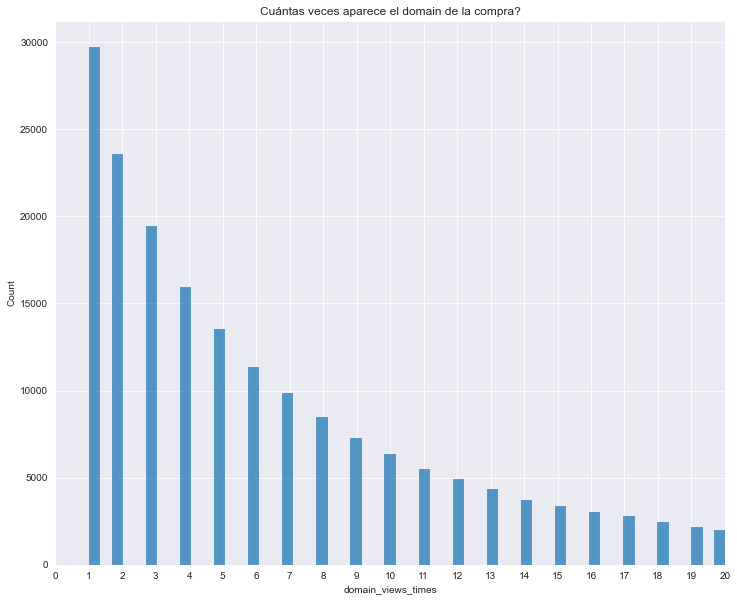

In [54]:
fig, ax = plt.subplots(figsize=(12,10))
sns.histplot(data=df_joined[df_joined.domain_was_searched == True]['domain_views_times'], ax=ax)
ax.set_xlim(0,20)
ax.set_xticks(list(range(21)))
ax.set_title('Cuántas veces aparece el domain de la compra?')

(0.0, 2000.0)

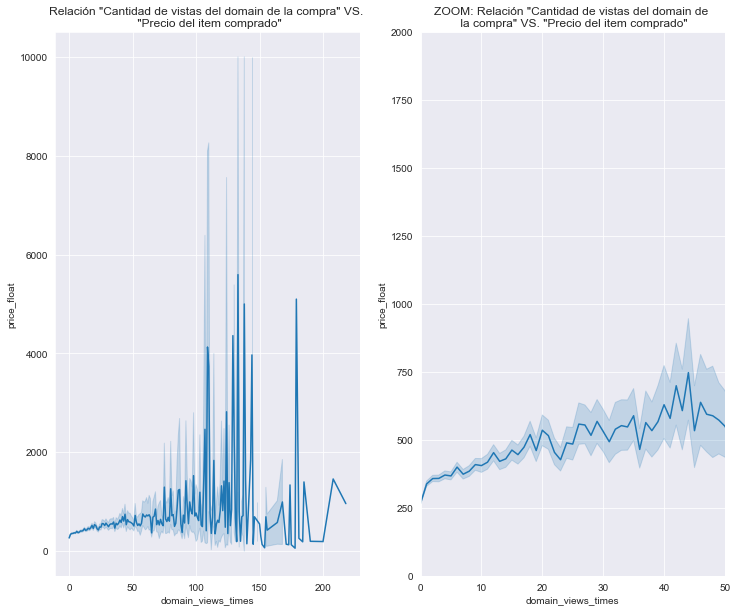

In [55]:
fig, axes = plt.subplots(1,2,figsize=(12,10))
sns.lineplot(data=df_joined[(df_joined.price_float < 25000) ], x='domain_views_times', y='price_float', ax=axes[0])
sns.lineplot(data=df_joined[(df_joined.price_float < 25000) ], x='domain_views_times', y='price_float', ax=axes[1])
axes[0].set_title('Relación "Cantidad de vistas del domain de la compra" VS. \n "Precio del item comprado"')
axes[1].set_title('ZOOM: Relación "Cantidad de vistas del domain de \n la compra" VS. "Precio del item comprado"')
axes[1].set_xlim(0,50)
axes[1].set_ylim(0,2000)

Pareciera haber una tendencia CRECIENTE (!) entre la cantidad de veces que un user mira el domain de la compra, y el precio del item que elige: A mayor análisis, mayor precio promedio.... O al revés: las cosas que son más caras requieren mayor análisis. Esto nos permite predecir que si un user miró 2 domain sólo 1 vez cada uno, y un domain corresponde a items de alto valor, lo más probable es que compre el otro, ya que para items de alto valor la gente mira y compara más.

##Cuántos domains diferentes fueron vistos

In [56]:
df_joined['unique_domains_viewed'] = df_joined.apply(lambda row: len(set([item_domain_dict[history['event_info']] for history in row['user_history'] if history['event_type'] == 'view'])), axis=1)


Text(0.5, 1.0, 'Cuántos domains diferentes fueron vistos')

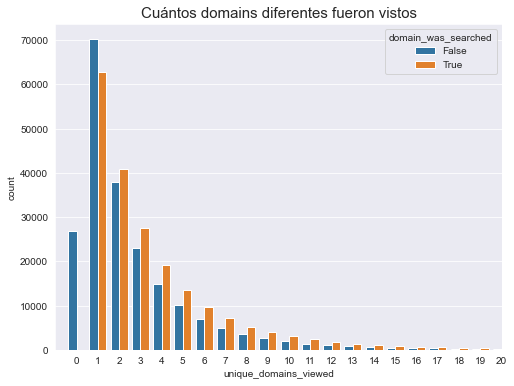

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=df_joined, x='unique_domains_viewed',
              ax=ax, hue='domain_was_searched')

# ax.set_xticks(list(range(30)))
ax.set_xlim(-1,20)
ax.set_title('Cuántos domains diferentes fueron vistos', fontdict={'fontsize':15})

##Relación vistas del domain de la compra / vistas totales:

<AxesSubplot:ylabel='Count'>

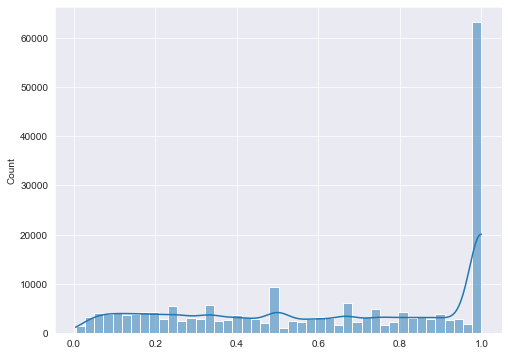

In [58]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=df_joined[df_joined.domain_was_searched == True]['domain_views_times'] / df_joined[df_joined.domain_was_searched == True]['view_count'], 
             ax=ax, kde=True)
# ax.set_xlim(0,20)

## Análisis de Títulos 

### ¿Cómo se relacionan los títulos de los ítems vistos y las búsquedas con el título del ítem comprado?


*   Para responder la siguiente pregunta decidimos comparar los titulos de los articulos buscados/vistos con los titulos de los articulos comprados. Como una primera aproximacion, decidimos comparar la primer palabra de cada titulo. Si coinciden ambas palabras, asumiremos que el comprador busco previamente lo que luego compro. 

In [59]:
#El siguiente codigo desglosa la columna user_history del df. Se obtiene un nuevo df (final_df)
#contiene las columnas de df y las columnas event_type, event_timestamp y event_info. 

import time
start_time = time.time()


total_users=len(df)

df['user_id']=np.arange(1,total_users+1)
df.set_index(df.user_id,inplace=True)

new_df=pd.DataFrame()
new_df2=pd.DataFrame()

print("Data Import: --- %s seconds ---" % (time.time() - start_time))

def clean_json(idx,col):
    parsed = pd.json_normalize(col)
    parsed['user_id']=idx
    return parsed

print('Desglosando user_history...')

for label, content in df.user_history.items():
  newcol=clean_json(label,content)
  if label==0:
    new_df=newcol
  else:
    new_df=new_df.append(newcol)
    if (np.mod(label,1000)==0): ## ir cada 1000 parece ser lo más optimo. 
        new_df2 = new_df2.append(new_df)
        del new_df
        new_df=pd.DataFrame()
        print(label)
    if (np.mod(label,20000)==0):
        print('Desglosando user_history...')
  del newcol
        

new_df2.set_index(new_df2.user_id,inplace=True)
new_df2

final_df=new_df2.join(df.item_bought,how='left')

final_df.to_csv('final_df.csv')

Data Import: --- 0.00697779655456543 seconds ---
Desglosando user_history...
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
Desglosando user_history...
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
Desglosando user_history...
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
Desglosando user_history...
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
Desglosando user_history...
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
Desglosando user_history...
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
Desglosando user_history...
121000
122000
123000
12

In [60]:
idf.rename(columns = {'item_id':'item_bought'},inplace=True)
#luego se selecciona esa col como key para hacer el join

idf.set_index(idf.item_bought,inplace=True)

#finalmente, uno con df_final. 

join_df=final_df.join(idf,how='left', on='item_bought',lsuffix='-Train-Data')


#Se renombran las columnas asociadas al item comprado con el fin de distinguirlas:

join_df.rename(columns = {'domain_id':'domain_id_bought'},inplace=True)
join_df.rename(columns = {'price':'price_bought'},inplace=True)
join_df.rename(columns = {'category_id':'category_id_bought'},inplace=True)
join_df.rename(columns = {'condition':'condition_bought'},inplace=True)
del join_df['product_id']
join_df.rename(columns = {'title':'title_bought'},inplace=True)

#Ahora se une el df anterior con los datos de item_data los items de "event_info". 
idf.rename(columns = {'item_bought':'event_info'},inplace=True)

#luego se selecciona esa col (event_info) como key para hacer el join:

idf.set_index(idf.event_info,inplace=True)

#finalmente, se une todo.

new_join_df=join_df.join(idf,how='left', on='event_info',lsuffix='Train-Data-')

# Se eligen columnas de interes: 

all_join = new_join_df[['event_infoTrain-Data-', 
                        'title', 'title_bought', 'domain_id','user_id','event_type',
                        'event_timestamp','item_bought-Train-Data']]
                       
##Se reemplazan los nan de la columna "title" con los valores de event_info. De ese modo, nos
#queda la columna title completa ya sea con el string de busqueda o con el titulo del item_id. 
all_join['title'] = all_join['title'].fillna(all_join['event_infoTrain-Data-'])

#Entonces podemos asi "comparar" directamente las columnas title & title_bought, con el fin de ver
#si hay coincidencias entre lo buscado/visto y lo comprado. 

#Agregamos columna de interes para los calculos:

all_join['index']=np.arange(1,len(all_join)+1,1)

#seteamos el index para desp poder splitear en funcion del indice cada celda de "title"!
all_join.set_index('index',inplace=True)

C:\Users\pipin\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pipin\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
#Definimos la funcion que splitea los titulos. 
def split(cell):
  aux=cell.split(sep=' ')[0].lower() # Split string into list of items and remain 1st element
  
  return aux

#Aplicamos la funcion a las columnas "title" y "bought_title"

# Create a new column with the 1st word 
all_join.loc[:, 'title_first_word'] = all_join.title\
    .apply(split)   # data.loc[<row selection>, <column selection>]

all_join.loc[:, 'bought_first_word'] = all_join.title_bought\
    .apply(split)   # data.loc[<row selection>, <column selection>]

C:\Users\pipin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\pipin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [62]:
#Buscamos coincidencias entre las nuevas columnas a ver si la gente compro lo que busco/vio. 

search_and_bought_df=all_join[(all_join.title_first_word == all_join.bought_first_word)]

copy_search_and_bought_df=search_and_bought_df.copy() #usaremos este df luego.

# eliminamos duplicados del mismo usuario
search_and_bought_df=search_and_bought_df.drop_duplicates(subset=['user_id'],keep='last')

C:\Users\pipin\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Event type before purchase')

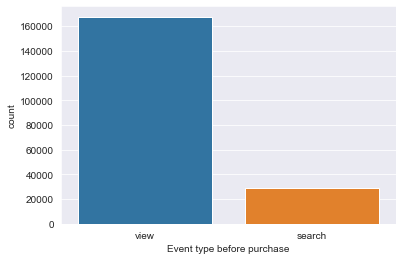

In [63]:
#Finalmente graficamos la cantidad de tipos de eventos donde se busco/vio lo que luego se compró:

import seaborn

seaborn.countplot(search_and_bought_df.event_type)
plt.xlabel('Event type before purchase')

Del gráfico anterior, observamos que alrededor del 80% de los items comprados fueron vistos con anterioridad al menos 2 hs antes de la compra y hasta 1 semana antes. El 20% restante de los items comprados fueron solo buscados en ese lapso de tiempo.  

###¿Cuántas veces aparece cada ítem comprado en nuestro dataset?


*   Entendemos que nos pregunta cuantas veces fue comprado un mismo item. Eso vamos a responder.


C:\Users\pipin\Anaconda3\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 0, 'Item bought')

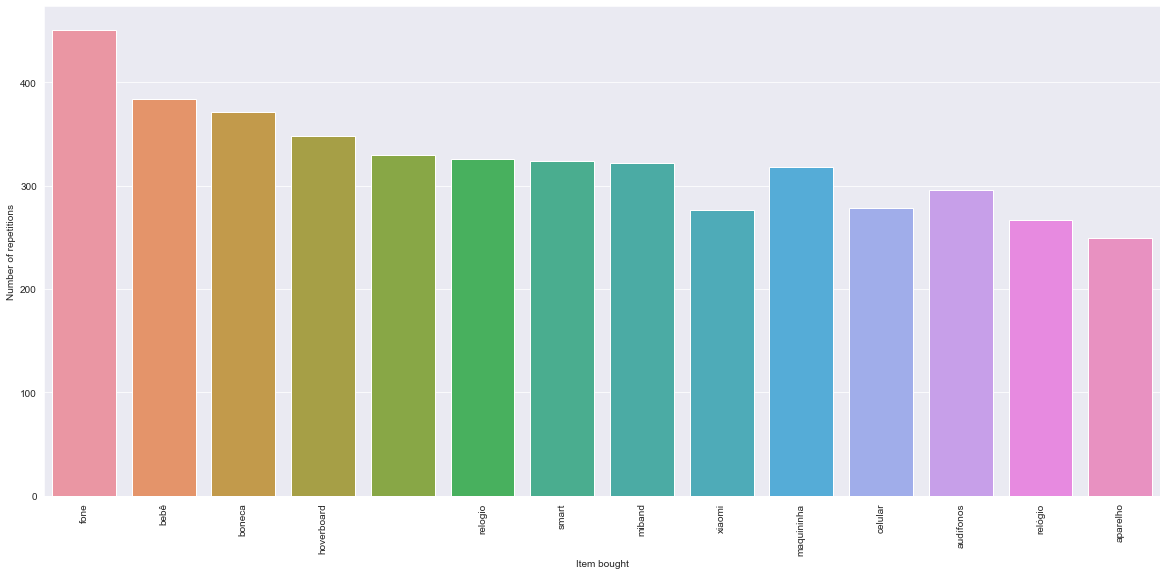

In [64]:
##Queremos ver cuantas veces aparece el mismo item comprado en la columna "item_bought"

#1) # eliminamos duplicados del mismo usuario para evitar contar la misma compra. 

new_join_df=new_join_df.drop_duplicates(subset=['user_id'],keep='first')

#2) Contamos los items duplicados en la columna "item_bought" y a la serie resultante la 
# transformamos en dataframe

dup_items= new_join_df.item_bought.value_counts()

dup_items=dup_items.to_frame()
#3) #Reacomodamos el df obtenido

dup_items.rename(columns={"item_bought":"repetitions"},inplace=True)
#dup_items.rename(columns={'Unnamed: 0':'item_bought'},inplace=True)
dup_items.index.name='item_bought'
#Armamos otro df que contenga el titulo del item comprado 
#y la columna con la primera palabra del titulo.

another_df=all_join[['item_bought-Train-Data','title_bought','bought_first_word']]

another_df.set_index('item_bought-Train-Data',inplace=True)
another_df.rename(columns={'item_bought-Train-Data':'item_bought'},inplace=True)
#Juntamos este df con el que teniamos de items duplicados usando como key la columna item_bought.
dup_items_2=dup_items.join(another_df,how='left',on='item_bought')

#Descartamos las filas duplicadas que vienen con another_df

dup_items_2=dup_items_2.drop_duplicates()

#Nos quedamos con los 20 articulos mas vendidos para graficar.
dup_items_3=dup_items_2[:20]

#Visualizamos los resultados obtenidos.

import seaborn
plt.figure(figsize=(20,9))
seaborn.barplot(x=dup_items_3.bought_first_word,y=dup_items_3.repetitions,ci=None)
plt.xticks(rotation=90)
plt.ylabel('Number of repetitions')
plt.xlabel('Item bought')



##Análisis de los Timestamps


###Están ordenados los events???
Sí. Dentro de la list del user history, los eventos van incrementando en datetime.

In [65]:
# def events_are_ordered(list_of_events):
#   if len(list_of_events) == 1:
#     return True
#   else:
#     date = datetime.strptime(list_of_events[0]['event_timestamp'],'%Y-%m-%dT%H:%M:%S.%f%z')
#     for event in list_of_events[1:]:
#       if datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z') < date:
#         return False
#       else:
#         date = datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
#     return True

# sum(df.user_history.apply(events_are_ordered) == False)


### Probabilidad de que una view corresponda al domain de la compra, conforme pasa el tiempo:

In [66]:
# df_joined['extended_user_history'] = df_joined.user_history.apply(extend_user_history)
def list_of_deltas(row):
  deltas_list = []
  if row.domain_was_searched:
    if len(row.user_history) == 1:
      deltas_list.append(timedelta(0))
    else:
      most_recent = row.user_history[-1]
      for event in row.user_history:
        if event['event_type'] == 'view':
          if item_domain_dict[event['event_info']] == row.domain_id:
            deltas_list.append(datetime.strptime(most_recent['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z') - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z'))
  return deltas_list
deltas_flat_list = [item for sublist in df_joined.apply(list_of_deltas, axis=1) for item in sublist]
delta_hours_list = [delta.total_seconds()/60/60 for delta in deltas_flat_list]




In [67]:
def list_of_deltas_diff_domain(row):
  deltas_list = []
  if row.domain_was_searched:
    if len(row.user_history) == 1:
      deltas_list.append(timedelta(0))
    else:
      most_recent = row.user_history[-1]
      for event in row.user_history:
        if event['event_type'] == 'view':
          if item_domain_dict[event['event_info']] != row.domain_id:
            deltas_list.append(datetime.strptime(most_recent['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z') - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z'))
  return deltas_list
deltas_flat_list_diff_domain = [item for sublist in df_joined.apply(list_of_deltas_diff_domain, axis=1) for item in sublist]
delta_hours_list_diff_domain = [delta.total_seconds()/60/60 for delta in deltas_flat_list_diff_domain]


In [68]:
domain_types = ['b_domain' for i in range(len(delta_hours_list))] + ['diff_domain' for i in range(len(delta_hours_list_diff_domain))]
deltas_list_complete = delta_hours_list + delta_hours_list_diff_domain
deltas_charts = pd.DataFrame(list(zip(deltas_list_complete, 
                                      domain_types)),
                             columns=['delta','domain_type'] )

Text(0.5, 1.0, 'Distribución de cantidad de vistas, según el delta de hora \n separado por vistas del domain de la compra y de otros')

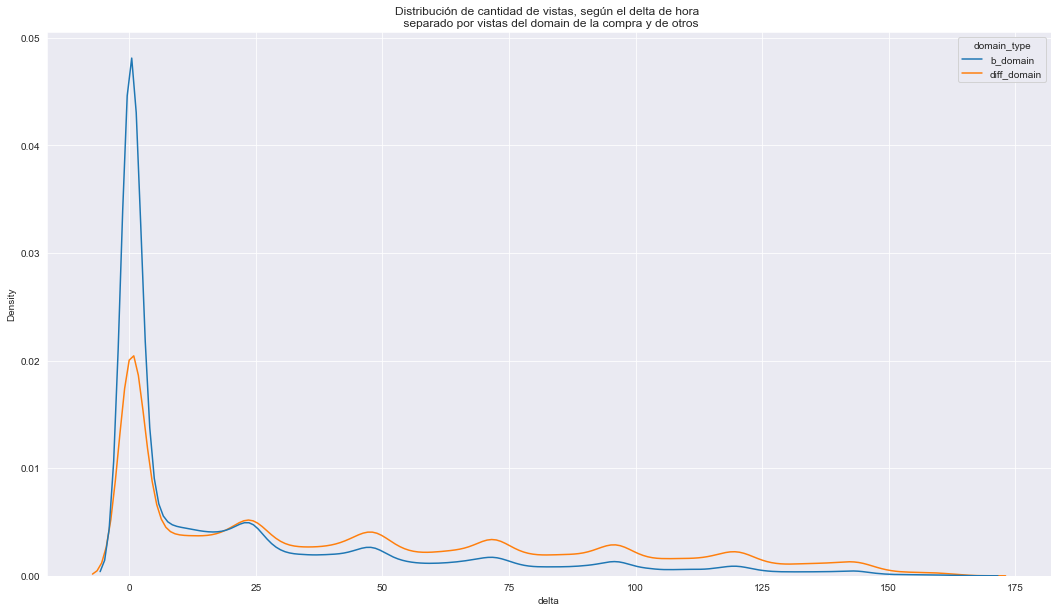

In [69]:
fig, ax = plt.subplots(figsize=(18,10))
sns.kdeplot(deltas_charts.delta, hue=deltas_charts.domain_type, ax=ax)
ax.set_title('Distribución de cantidad de vistas, según el delta de hora \n separado por vistas del domain de la compra y de otros')

In [70]:
deltas_charts.sort_values('delta', ascending=True,inplace=True)
deltas_charts['hour_range'] = np.floor(deltas_charts.delta)
deltas_charts['domain_type_cat'] = deltas_charts.domain_type.apply(lambda x: 1 if x == 'b_domain' else 0)

Text(0.5, 1.0, 'Porcentaje de vistas del domain/ vistas totales \n según el delta de horas de las vistas')

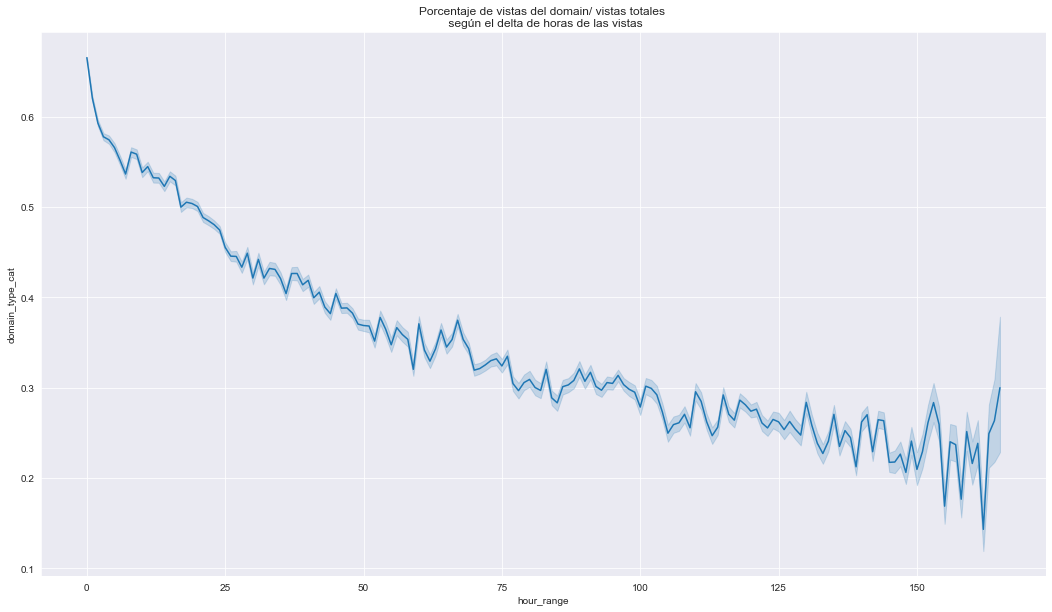

In [71]:
fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(data=deltas_charts, x='hour_range', y='domain_type_cat', ax=ax)
ax.set_title('Porcentaje de vistas del domain/ vistas totales \n según el delta de horas de las vistas')


### Diferencia temporal entre el evento inicial y final asociado a un item finalmente comprado. 

C:\Users\pipin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\pipin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\pipin\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Text(0.5, 0, 'Time differences between 1st & last event asociated to the item bought [hours]')

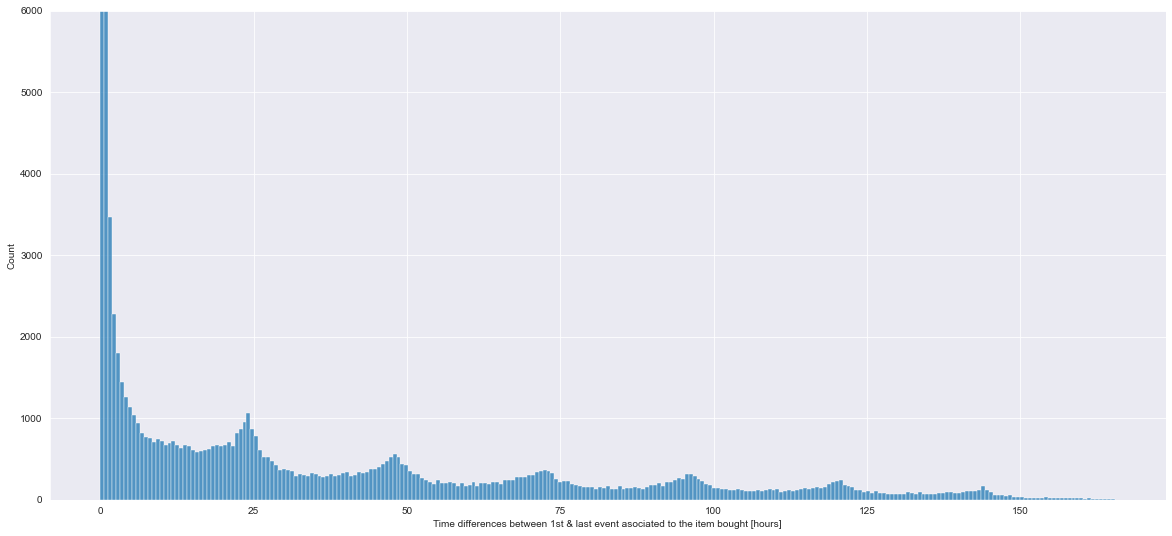

In [73]:
#Queremos ver ahora la diferencia temporal entre el primer y el ultimo evento registrado asociado
#al item de compra. Para ello, vamos a usar la copia del dataframe que creamos previamente que incluian
#las columnas con la primer palabra de las columnas "title" y "title_bought"

# Armamos dos nuevos df eliminando los eventos repetidos 
#asociados a un mismo usuario y aun mismo item. Nos quedamos solamente con el primer y el
#ultimo evento:

search_and_bought_df_1=copy_search_and_bought_df.drop_duplicates(subset=['user_id'],keep='first')
search_and_bought_df_2=copy_search_and_bought_df.drop_duplicates(subset=['user_id'],keep='last')

# Calcularemos la diferencia de tiempo entre el primer y el ultimo a partir de la sig funcion:

#import datetime

def datetype(date_time_str):

  date_time_str=date_time_str[0:23]
  
  date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%dT%H:%M:%S.%f')
  
  return date_time_obj

# Creamos nuevas columnas en los df que incluyan los tiempos iniciales y finales respectivamente:

search_and_bought_df_1.loc[:,'event_ini'] = search_and_bought_df_1.event_timestamp.apply(datetype) 
search_and_bought_df_2.loc[:,'event_end'] = search_and_bought_df_2.event_timestamp.apply(datetype) 

search_and_bought_df_1.set_index('user_id',inplace=True)
search_and_bought_df_2.set_index('user_id',inplace=True)

# Calculamos la diferencia entre estos tiempos en una nueva col aplicando la funcion anterior:

search_and_bought_df_1.loc[:,'time_diff']=search_and_bought_df_2['event_end']-search_and_bought_df_1['event_ini']

search_and_bought_df_1.time_diff

#Pasamos a horas:

search_and_bought_df_1['time_diff_hours']= search_and_bought_df_1.time_diff/pd.Timedelta(hours=1)

search_and_bought_df_1[search_and_bought_df_1.time_diff_hours>20]

#Graficamos:

import seaborn
plt.figure(figsize=(20,9))
a=seaborn.histplot(search_and_bought_df_1.time_diff_hours)
plt.ylim(0,6000)
#a.set_yscale("exp")
plt.xlabel('Time differences between 1st & last event asociated to the item bought [hours]')

Lo que se observa en la grafica es curioso. Por un lado, vemos que la mayoria de las personas compradoras "deciden" en no mas de 4hs lo que van a comprar al cabo de 2hs. Por otro lado, se observan pequeños picos a las 24, 48, 72, 96..hs y creemos que esto puede deberse a que algunas personas se conectan siempre a la misma hora a ML a continuar sus busquedas. Si bien no es la mayoria podria ser util conocer los horarios de preferencia de conexion de cada usuario.  

###Sirve categorizar a los compradores según horas en las que hacen searches y views?

##Preguntas aún no respondidas:

### ¿Existen palabras que estén dominando nuestros títulos y no aportan valor semántico?


###Sirve categorizar a los compradores según la cantidad de views o searches que hacen?

### Posibilidades: Eliminar a todos los que no vieron el dominio comprado, y entrenar unicamente con el otro 50%

### Entrenar con los dos grupos de datos por separado. Analizar si entre el 50% que no busco el dominio de la compra, existen patrones en comun: buscan en random? algun otro patron que nos permita identificarlos?

### Chequear variable tiempo... Se puede poner un weight según lejanía de la view/search. Pero esto es peligroso, porque para la mayor parte de los casos, donde tenemos pocos events, es imposible definir si los mismos ocurrieron hace 2 semanas o hace 2 horas.

### Chequear % de vistas del domain de la compra, separado por domain
### Interpretar mediante NLP las searches a un domain (o a un product si se da)
### Agregar una columna con el domain predicho por las searches, o incluso una matriz con domains. Re-analizar distribucion de gente que vio ALGO sobre su producto de compra, teniendo en cuenta las searches (quizás no entraron a  ninguna view, pero sí estuvieron buscando sobre el producto)

In [ ]:
# # !pip install nltk
# import nltk
# nltk.download('all')

In [ ]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

In [ ]:
# X ="horror horror horror horror"
# Y ="horror horror horror horror Lights out is ble bli blu asd dfre"
  
# # tokenization
# X_list = word_tokenize(X) 
# Y_list = word_tokenize(Y)
  
# # sw contains the list of stopwords
# sw = stopwords.words('english') 
# l1 =[];l2 =[]
  
# # remove stop words from the string
# X_set = {w for w in X_list if not w in sw} 
# Y_set = {w for w in Y_list if not w in sw}
  
# # form a set containing keywords of both strings 
# rvector = X_set.union(Y_set) 
# for w in rvector:
#     if w in X_set: l1.append(1) # create a vector
#     else: l1.append(0)
#     if w in Y_set: l2.append(1)
#     else: l2.append(0)
# c = 0
  
# # cosine formula 
# for i in range(len(rvector)):
#         c+= l1[i]*l2[i]
# cosine = c / float((sum(l1)*sum(l2))**0.5)
# print("similarity: ", cosine)